# Cách tạo Class Dataset


In [56]:
!pip install tqdm

In [57]:
import glob
import os.path as osp
import random
import numpy as np
import json 
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms
from tqdm import tqdm 

In [3]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

torch.backends.cudnn.deterministic =True
torch.backends.cudnn.benmark =False
#chay tren GPU de dc ket qua giong nhau

In [4]:
class ImageTransformer(): # tien xu ly buc anh cho phan trainning
    def __init__(self, resize,mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5 ,1.0)),
                transforms.RandomHorizontalFlip(0.5),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val' : transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)
    
    

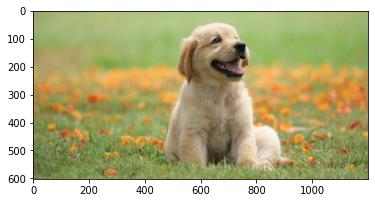

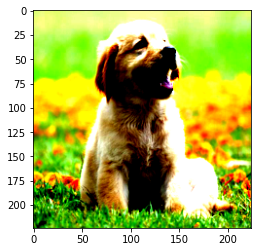

In [5]:
img_file_path ='./data/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'
img= Image.open(img_file_path)

plt.imshow(img)
plt.show()

size = 224
mean = (0.485, 0.456, 0.406) 
std = (0.229, 0.224, 0.225)

transform = ImageTransformer(size,mean,std)
img_transformed = transform(img, phase='train')

# lúc này ảnh đang ở dạng tensor nên cần chuyển về numpy và đổi thứ tự
# (channel,height,width) --> (height,width,channel) -->(0,1)
img_transformed = img_transformed.numpy().transpose(1,2,0)
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [6]:
!dir data


 Volume in drive C is Windows 10
 Volume Serial Number is 0C3D-9ADF

 Directory of C:\Users\Admin\Desktop\learn_10Mar\data

03/16/2022  11:25 PM    <DIR>          .
03/16/2022  11:25 PM    <DIR>          ..
03/13/2022  04:43 PM            80,864 dog-puppy-on-garden-royalty-free-image-1586966191.jpg
03/16/2022  11:25 PM    <DIR>          hymenoptera_data
               1 File(s)         80,864 bytes
               3 Dir(s)  13,626,986,496 bytes free


In [7]:
# liệt kê các path dẫn đến ảnh vào 1 list rồi truyền list đó vào data_class
def make_datapath_list(phase='train'):
    rootpath ="./data/hymenoptera_data/"
    target_path = osp.join(rootpath+ phase+ "/**/*.jpg")
    # print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
    return path_list

In [8]:
path_list = make_datapath_list('train')

In [9]:
len(path_list)

243

In [10]:
path_list[:10]

['./data/hymenoptera_data/train\\ants\\0013035.jpg',
 './data/hymenoptera_data/train\\ants\\1030023514_aad5c608f9.jpg',
 './data/hymenoptera_data/train\\ants\\1095476100_3906d8afde.jpg',
 './data/hymenoptera_data/train\\ants\\1099452230_d1949d3250.jpg',
 './data/hymenoptera_data/train\\ants\\116570827_e9c126745d.jpg',
 './data/hymenoptera_data/train\\ants\\1225872729_6f0856588f.jpg',
 './data/hymenoptera_data/train\\ants\\1262877379_64fcada201.jpg',
 './data/hymenoptera_data/train\\ants\\1269756697_0bce92cdab.jpg',
 './data/hymenoptera_data/train\\ants\\1286984635_5119e80de1.jpg',
 './data/hymenoptera_data/train\\ants\\132478121_2a430adea2.jpg']

In [11]:
train_list = make_datapath_list('train')
val_list = make_datapath_list('val')

In [12]:
class MyDataset(data.Dataset): # tao 1 dataset///
    def __init__(self,file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        if self.phase == "train":
            label = img_path[30:34]
        elif self.phase == "val":
            label = img_path[28:32]
        
        if label =="ants":
            label = 0
        elif label == "bees":
            label = 1
            
        return img_transformed, label

In [13]:
train_dataset = MyDataset(train_list,transform=ImageTransformer(size,mean,std),phase="train")

In [14]:
val_dataset = MyDataset(val_list,transform=ImageTransformer(size,mean,std),phase="val")

In [15]:
index = 0
# print(train_dataset.__len__())
img, label = train_dataset.__getitem__(index)
print(img.shape)
print(label)

torch.Size([3, 224, 224])
0


# Tạo dataloader


In [20]:
batch_size = 4   # nhom anh

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle = False)

datalaoder_dict = {"train": train_dataloader , "val": val_dataloader}


In [21]:
batch_iterator = iter(datalaoder_dict["train"])
inputs, labels = next(batch_iterator)

In [22]:
print(inputs.size()) #inputs.shape() 
print(labels)

torch.Size([4, 3, 224, 224])
tensor([1, 0, 1, 0])


# Tạo Network, Định nghĩa loss, Thiết lập optimize, Thử nghiệm training

## Network


In [32]:
use_pretrained = True
net = models.vgg16(pretrained = use_pretrained)
net.classifier[6] = nn.Linear(in_features = 4096, out_features = 2)
# print(net)

# setting mode 
net = net.train()


## loss

In [33]:
criterior = nn.CrossEntropyLoss()

## optimizer

In [49]:
params_to_update = []

update_params_name = ["classifier.6.weight","classifier.7.bias"]

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

print(params_to_update)
    

classifier.6.weight
[Parameter containing:
tensor([[-0.0037,  0.0054,  0.0139,  ...,  0.0075, -0.0003, -0.0034],
        [-0.0005,  0.0149,  0.0021,  ...,  0.0050,  0.0146,  0.0153]],
       requires_grad=True)]


In [50]:
optimizer = optim.SGD(params = net.parameters(), lr = 0.001, momentum = 0.9)

# Kiểm thử


In [58]:
# training
def train_model(net, datalaoder_dict, criterior, optimizer, num_epochs):
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        
        for phase in ["train", "val"]:
            if phase == "train":
                net.train()
            else:
                net.eval()
            epoch_loss = 0.0
            epoch_corrects = 0
            
            if (epoch == 0) and (phase == "train"):
                continue
            for inputs, labels in tqdm(datalaoder_dict[phase]):
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = net(inputs)
                    loss = criterior(outputs, labels)
                    _, preds = torch.max(outputs,1)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() *inputs.size(0) # lay patch_size
                    epoch_corrects += torch.sum(preds==labels.data)
                    
            epoch_loss = epoch_loss / len(datalaoder_dict[phase].dataset)
            epoch_accuracy = epoch_corrects.double() / len(datalaoder_dict[phase].dataset)
            
            print("{} Loss:{:.4f} Accuracy:{:.4f}".format(phase, epoch_loss, epoch_accuracy))

In [59]:
num_epochs = 2
train_model(net , datalaoder_dict, criterior, optimizer, num_epochs)

Epoch 0/2


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [01:28<00:00,  2.27s/it]


val Loss:0.6771 Accuracy:0.5425
Epoch 1/2


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:32<00:00,  2.50s/it]


train Loss:0.2922 Accuracy:0.9012


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [01:30<00:00,  2.32s/it]

val Loss:0.1305 Accuracy:0.9477
